In [1]:
%%capture
pip install plotly pandas statsmodels kaleido scipy nbformat jinja2

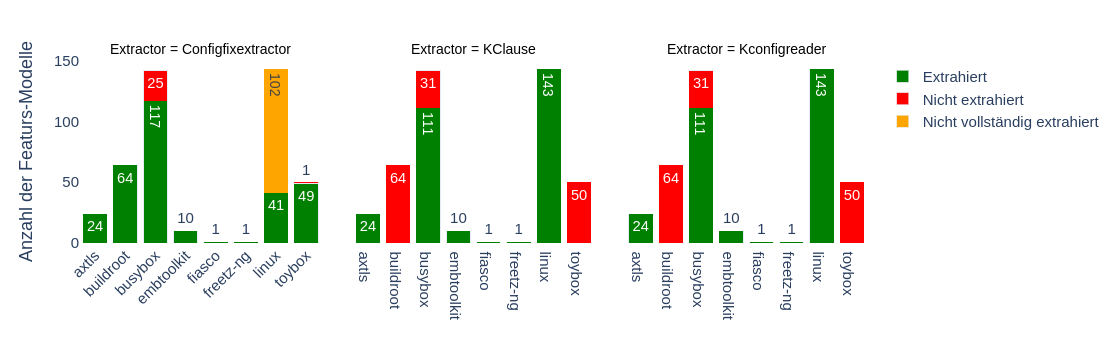

In [152]:
import pandas as pd
import plotly.express as px

# Daten importieren
file_configfixextractor = '/home/rami/configFixextractor/kconfig/output.csv'
file_kmax = '/home/rami/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Kconfigreader/kconfig/output.csv'

df_configfixextractor = pd.read_csv(file_configfixextractor)
df_kmax = pd.read_csv(file_kmax)
df_Kconfigreader = pd.read_csv(file_Kconfigreader)

# Relevante Spalten extrahieren und 'Extractor' hinzufügen
df_configfixextractor_filtered = df_configfixextractor[['system', 'revision', 'model-file']].copy()
df_configfixextractor_filtered['Extractor'] = 'Configfixextractor'

df_kmax_filtered = df_kmax[['system', 'revision', 'model-file']].copy()
df_kmax_filtered['Extractor'] = 'KClause'

df_Kconfigreader_filtered = df_Kconfigreader[['system', 'revision', 'model-file']].copy()
df_Kconfigreader_filtered['Extractor'] = 'Kconfigreader'

# Alle DataFrames kombinieren
df_combined = pd.concat([df_configfixextractor_filtered, df_kmax_filtered, df_Kconfigreader_filtered], ignore_index=True)

# Status basierend auf 'model-file' für extrahierte und nicht extrahierte Modelle
df_combined['status'] = df_combined.apply(
    lambda row: 'Extrahierte Feature-Modelle' if pd.notna(row['model-file']) else 'Nicht extrahierte Feature-Modelle',
    axis=1
)


1+4

# Fehlerstatus für ConfigFixExtractor von v2.5.45 bis v4.18
def error_status(row):
    # Fehler nur für 'Configfixextractor' und wenn Revision zwischen v2.5.45 und v4.18 liegt
    if row['Extractor'] == 'Configfixextractor' and 'v2.5.45' <= row['revision'] <= 'v4.18':
        return 'Nicht vollständig extrahiert'
    if pd.notna(row['model-file']):
        return 'Extrahiert'
    return 'Nicht extrahiert'

df_combined['error_status'] = df_combined.apply(error_status, axis=1)

# Zusammenfassung der Daten für das Diagramm
df_summary_combined = df_combined.groupby(['system', 'status', 'Extractor', 'error_status']).size().reset_index(name='count')

# Diagramm erstellen
fig_combined = px.bar(
    df_summary_combined,
    x='system',
    y='count',
    color='error_status',  # Fehlerstatus als Farbkategorie
    facet_col='Extractor',  # Separate Diagramme für jeden Extractor
    labels={'count': 'Anzahl der Featurs-Modelle', 'system': '', 'status': 'Extraktionsstatus'},
    text='count',  # Anzahl der Werte anzeigen
    color_discrete_map={
        'Extrahiert': 'green',  
        'Nicht vollständig extrahiert': 'orange', 
        'Nicht extrahiert': 'red'  # Nicht extrahiert in rot
    },
    facet_col_spacing=0.04,  # Etwas Platz zwischen den Facetten
    facet_row_spacing=0.1    # Etwas Platz zwischen den Reihen
)

# Layout anpassen
fig_combined.update_layout(
    xaxis_title='',  # x-Achse nur einmalig in der Mitte
    font=dict(size=15),
    legend_title='',
    xaxis_tickangle=-45,
    barmode='stack',  # Stacked Bar für die verschiedenen Status
    plot_bgcolor='white',
    paper_bgcolor='white',
    yaxis=dict(
        showticklabels=True,  # y-Achse ohne Beschriftungen
        showgrid=True        # Kein Gitternetz
    ),
    title_x=0.5,  # Titel mittig ausrichten
    title={'text': '', 'x': 0.5, 'xanchor': 'center'},  # Globaler Titel hinzufügen
)

# Facetten Titel mit der Form "Extractor = Configfixextractor" anzeigen
fig_combined.for_each_annotation(lambda a: a.update(text=f"Extractor = {a.text.split('=')[-1]}", font_size=14, font_family="Arial", font_color="black"))

# Diagramm anzeigen
fig_combined.show()


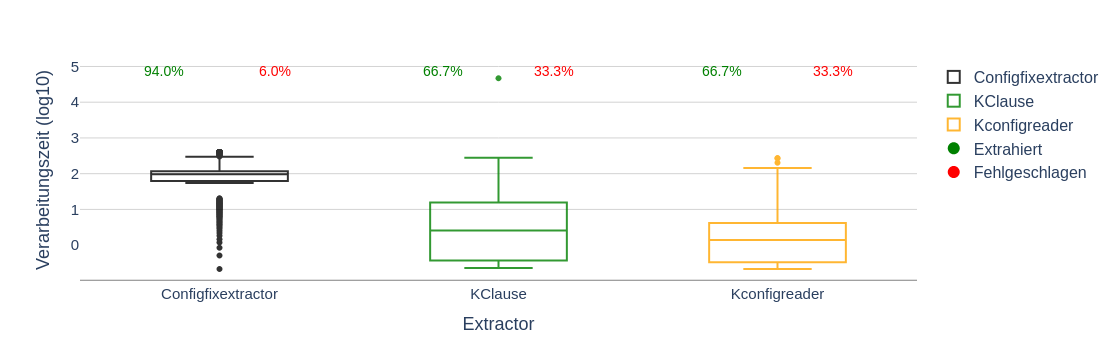

In [142]:
import pandas as pd
import plotly.express as px
from math import log10

# Die big_log10 Funktion für die Logarithmustransformation
def big_log10(val):
    return log10(val) if pd.notna(val) and val > 0 else pd.NA

# Daten importieren
file_configfixextractor = '/home/rami/configFixextractor/kconfig/output.csv'
file_kmax = '/home/rami/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Kconfigreader/kconfig/output.csv'

df_configfixextractor = pd.read_csv(file_configfixextractor)
df_kmax = pd.read_csv(file_kmax)
df_Kconfigreader = pd.read_csv(file_Kconfigreader)

# Hinzufügen des Extractors für jedes DataFrame
df_configfixextractor['Extractor'] = 'Configfixextractor'
df_kmax['Extractor'] = 'KClause'
df_Kconfigreader['Extractor'] = 'Kconfigreader'

# Zusammenführen der DataFrames
df_combined = pd.concat([df_configfixextractor[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
                         df_kmax[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
                         df_Kconfigreader[['system', 'revision', 'model-file', 'Extractor', 'model-time']]],
                        ignore_index=True)

# Sicherstellen, dass 'model-time' als numerischer Wert vorliegt
df_combined['model-time'] = pd.to_numeric(df_combined['model-time'], errors='coerce')

# Umwandlung von Nanosekunden in Sekunden
df_combined['model-time-seconds'] = df_combined['model-time'] / 1e9

# Anwendung der big_log10 Funktion auf die in Sekunden umgewandelte Zeit
df_combined['log_model_time'] = df_combined['model-time-seconds'].apply(lambda x: big_log10(x))

# Prozentwerte für extrahierte und nicht extrahierte Modelle berechnen
percent_values = (
    df_combined.assign(extracted_model_file=~df_combined['model-file'].isna())  # True, wenn 'model-file' vorhanden
    .groupby('Extractor')['extracted_model_file']
    .agg(total_cases='size', extracted_cases='sum')  # Gesamtanzahl und extrahierte Fälle
    .assign(
        not_extracted_cases=lambda x: x['total_cases'] - x['extracted_cases'],  # Nicht extrahierte Fälle
        percent_extracted=lambda x: (x['extracted_cases'] / x['total_cases']) * 100,
        percent_not_extracted=lambda x: (x['not_extracted_cases'] / x['total_cases']) * 100
    )
    .reset_index()
)

# Boxplot erstellen
fig_boxplot = px.box(
    df_combined,
    x='Extractor',
    y='log_model_time',  # Log-transformierte Verarbeitungszeit
    labels={'log_model_time': 'Logarithmierte Verarbeitungszeit (log10)', 'Extractor': 'Extractor'},
    title='',
    color='Extractor',
    color_discrete_map={
        'Configfixextractor': 'black',
        'KClause': 'green',
        'Kconfigreader': 'orange'
    }
)

fig_boxplot.update_traces(
    fillcolor='rgba(255, 255, 255, 0)',  # Keine Füllfarbe, nur Transparenz
    opacity=0.8  # Opacity einstellen (von 0 bis 1)
)
# Manuelle Legende für "Extrahiert" und "Fehlgeschlagen"
fig_boxplot.add_trace(
    go.Scatter(
        x=[None], y=[None], mode='markers', 
        marker=dict(color='green', size=10),
        name='Extrahiert'
    )
)
fig_boxplot.add_trace(
    go.Scatter(
        x=[None], y=[None], mode='markers', 
        marker=dict(color='red', size=10),
        name='Fehlgeschlagen'
    )
)
# Prozentwerte als Annotationen hinzufügen
for i, row in percent_values.iterrows():
    fig_boxplot.add_annotation(
        x=i - 0.2,  # Position etwas nach links verschieben
        y=df_combined['log_model_time'].max() + 0.2,  # Platzierung über dem Boxplot
        text=f"{row['percent_extracted']:.1f}%",
        showarrow=False,
        font=dict(color='green', size=14)  # Grün für "Extrahiert"
    )
    fig_boxplot.add_annotation(
        x=i + 0.2,  # Position etwas nach rechts verschieben
        y=df_combined['log_model_time'].max() + 0.2,  # Platzierung über dem Boxplot
        text=f"{row['percent_not_extracted']:.1f}%",
        showarrow=False,
        font=dict(color='red', size=14)  # Rot für "Fehlgeschlagen"
    )

# Layout anpassen
fig_boxplot.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=15),
    xaxis_title='Extractor',
    yaxis_title='Verarbeitungszeit (log10)',
    title_x=0.5,  
    yaxis=dict(
        showgrid=True,       
        gridcolor='lightgray'  
    ),
    xaxis=dict(
        showgrid=False,
        showline=True,
        linecolor='black',
        linewidth=0.5  
    ),
    legend=dict(
        title="",
        itemsizing='constant',
        font=dict(size=16),
        tracegroupgap=0,  
    )
)

# Diagramm anzeigen
fig_boxplot.show()


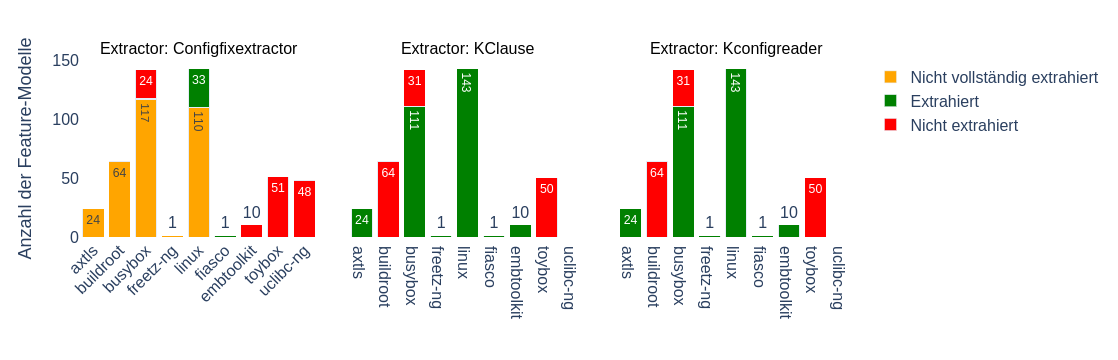

In [151]:
import pandas as pd
import plotly.express as px

# Daten importieren
file_configfixextractor = '/home/rami/configFixextractor_with_preprossesing/kconfig/output.csv'
file_kmax = '/home/rami/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Kconfigreader/kconfig/output.csv'

df_configfixextractor = pd.read_csv(file_configfixextractor)
df_kmax = pd.read_csv(file_kmax)
df_Kconfigreader = pd.read_csv(file_Kconfigreader)

# Relevante Spalten extrahieren und 'Extractor' hinzufügen
df_configfixextractor_filtered = df_configfixextractor[['system', 'revision', 'model-file']].copy()
df_configfixextractor_filtered['Extractor'] = 'Configfixextractor'

df_kmax_filtered = df_kmax[['system', 'revision', 'model-file']].copy()
df_kmax_filtered['Extractor'] = 'KClause'

df_Kconfigreader_filtered = df_Kconfigreader[['system', 'revision', 'model-file']].copy()
df_Kconfigreader_filtered['Extractor'] = 'Kconfigreader'

# Alle DataFrames kombinieren
df_combined = pd.concat([df_configfixextractor_filtered, df_kmax_filtered, df_Kconfigreader_filtered], ignore_index=True)

# Funktion zur Konvertierung von Versionsnummern in Tupel für sichere Vergleiche
def parse_version(version):
    try:
        # Ersetze 'release-', 'v' und '_' durch '.' für einheitliche Verarbeitung
        version = version.replace('release-', '').replace('v', '').replace('_', '.')
        version_tuple = tuple(map(int, version.split('.')))  # Konvertiere in Tupel mit Zahlen
        return version_tuple + (0,) * (3 - len(version_tuple))  # Ergänze fehlende Stellen mit 0
    except:
        return (0, 0, 0)  # Falls Fehler auftritt, Standardwert zurückgeben

# Funktion zur Klassifizierung des Fehlerstatus basierend auf System, Version und Extractor
def error_status(row):
    version_num = parse_version(row['revision'])  # Konvertiere Versionsnummer

    # 🔹 Bedingung für **axTLS** (release-1.0.0 bis release-2.0.0)
    if row['system'].lower() == 'axtls' and row['Extractor'] == 'Configfixextractor':
        if parse_version("release-1.0.0") <= version_num <= parse_version("release-2.0.0"):
            return 'Nicht vollständig extrahiert'

    # 🔹 Bedingung für **Linux** (v2.5.45 bis v4.18)
    if row['system'].lower() == 'linux' and row['Extractor'] == 'Configfixextractor':
        if parse_version("v2.5.45") <= version_num <= parse_version("v4.18"):
            return 'Nicht vollständig extrahiert'

    # 🔹 Bedingung für **BusyBox** (1.1.0 bis 1.36.1)
    if row['system'].lower() == 'busybox' and row['Extractor'] == 'Configfixextractor':
        if parse_version("1.1.0") <= version_num <= parse_version("1.36.1"):
            return 'Nicht vollständig extrahiert'

    # 🔹 Bedingung für **Buildroot** (2009.02 bis 2024.11)
    if row['system'].lower() == 'buildroot' and row['Extractor'] == 'Configfixextractor':
        if parse_version("2009.02") <= version_num <= parse_version("2024.11"):
            return 'Nicht vollständig extrahiert'

    if row['system'].lower() == 'freetz-ng' and row['Extractor'] == 'Configfixextractor':
        if parse_version("5c5a4d1d87ab8c9c6f121a13a8fc4f44c79700af") <= version_num <= parse_version("5c5a4d1d87ab8c9c6f121a13a8fc4f44c79700af"):
            return 'Nicht vollständig extrahiert'

    # 🔹 Falls eine Modell-Datei existiert, dann als "Extrahiert" markieren
    if pd.notna(row['model-file']):
        return 'Extrahiert'
    
    # 🔹 Falls keine der Bedingungen zutrifft → "Nicht extrahiert"
    return 'Nicht extrahiert'


df_combined['error_status'] = df_combined.apply(error_status, axis=1)

# Status für extrahierte/nicht extrahierte Modelle
df_combined['status'] = df_combined.apply(
    lambda row: 'Extrahierte Feature-Modelle' if pd.notna(row['model-file']) else 'Nicht extrahierte Feature-Modelle',
    axis=1
)

# Zusammenfassung der Daten für das Diagramm
df_summary_combined = df_combined.groupby(['system', 'status', 'Extractor', 'error_status']).size().reset_index(name='count')

# Diagramm erstellen
fig_combined = px.bar(
    df_summary_combined,
    x='system',
    y='count',
    color='error_status',  # Fehlerstatus als Farbkategorie
    facet_col='Extractor',  # Separate Diagramme für jeden Extractor
    labels={'count': 'Anzahl der Feature-Modelle', 'system': '', 'status': 'Extraktionsstatus'},
    text='count',  # Anzahl der Werte anzeigen
    color_discrete_map={
        'Extrahiert': 'green',  
        'Nicht vollständig extrahiert': 'orange', 
        'Nicht extrahiert': 'red'  # Nicht extrahiert in rot
    },
    facet_col_spacing=0.04,  # Etwas Platz zwischen den Facetten
    facet_row_spacing=0.1    # Etwas Platz zwischen den Reihen
)

# Layout anpassen (Schriftgrößen & Achsentitel)
fig_combined.update_layout(
    font=dict(size=16),  # Allgemeine Schriftgröße erhöhen
    legend_title='',
    xaxis_tickangle=-45,
    barmode='stack',  # Stacked Bar für die verschiedenen Status
    plot_bgcolor='white',
    paper_bgcolor='white',
    yaxis=dict(
        title='Anzahl der Feature-Modelle',  # Deutlicher Achsentitel
        showticklabels=True,  # y-Achse anzeigen
        showgrid=True,  # Gitternetz aktivieren
        title_font=dict(size=18)  # Größere Schrift für y-Achsentitel
    ),
    title_x=0.5,  # Titel mittig ausrichten
    title={'text': '', 'x': 0.5, 'xanchor': 'center'},  # Globaler Titel hinzufügen
)

# Facetten Titel anpassen
fig_combined.for_each_annotation(lambda a: a.update(text=f"Extractor: {a.text.split('=')[-1]}", font_size=16, font_color="black"))



# Diagramm anzeigen
fig_combined.show()
